In [530]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
import numpy as np
import mne
import os
import sys
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
mne.set_log_level('WARNING')

## EEG Motor Movement/Imagery Dataset

1. https://www.physionet.org/content/eegmmidb/1.0.0/
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE Transactions on Biomedical Engineering 51(6):1034-1043, 2004
3. https://mne.tools/stable/auto_examples/index.html

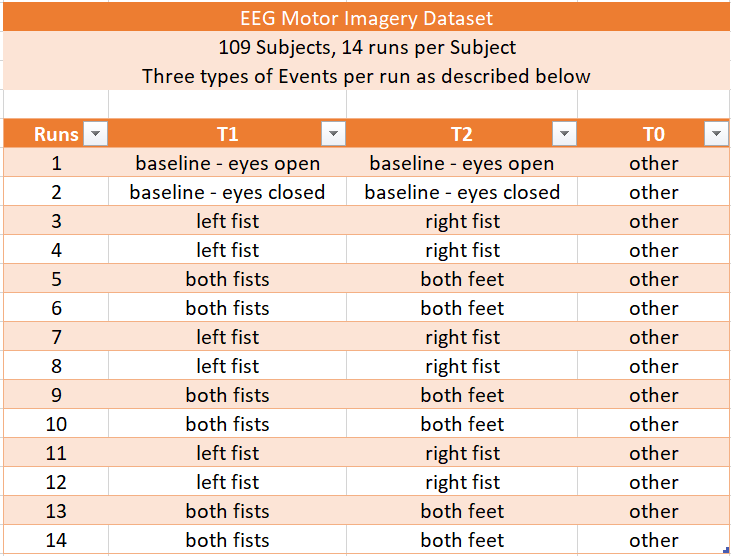

### Defining a motorImagery class for Data Loading and Pre-processing

In [9]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=0., tmax=4.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False, channels=None):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            if channels is None:
                self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
            else:
                self.epochs = self.epochs.pick_channels(channels)
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False, channels=None):
        self.return_epochs(channel_selection=channel_selection, channels=channels)
        return self.epochs.get_data(), self.labels

#### Loading data using the motorImagery class

In [7]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [10]:
dataset_path = os.path.join("H:\\","BCI Project","eeg-motor-movementimagery-dataset-1.0.0","files\\")
subjects = [1,2,3,4,5]
runs = [6,10,14]
eeg = motorImagery(dataset_path, subjects, runs)

#eeg.apply_filter(freq=(7,30))
#X, y = eeg.get_X_y()
#X.shape

Loading files at index: [5, 9, 13, 19, 23, 27, 33, 37, 41, 47, 51, 55, 61, 65, 69]
Loading file #15/15: H:\BCI Project\eeg-motor-movementimagery-dataset-1.0.0\files\S005/S005R14.edf

In [15]:
print(eeg.raw.ch_names)

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


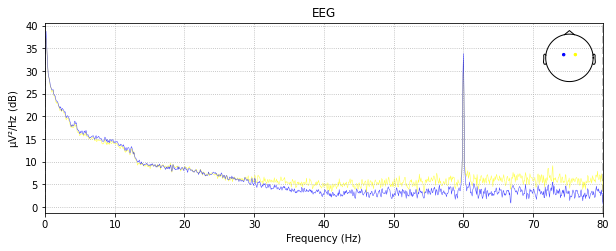

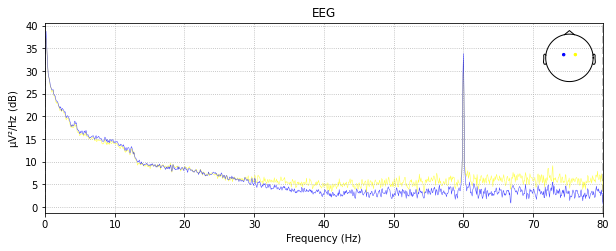

In [159]:
eeg.raw.plot_psd(picks=['C1', 'C2'])

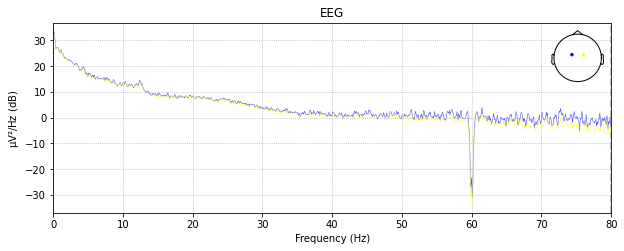

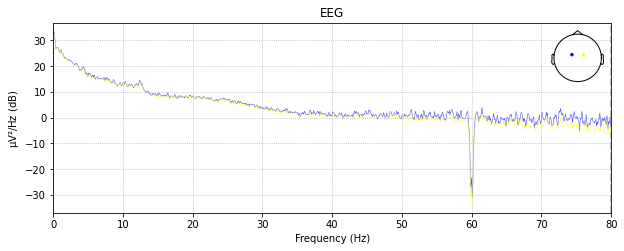

In [11]:
raw = eeg.raw.copy()
raw.notch_filter(60, filter_length='auto', phase='zero')
raw.plot_psd(picks=['C1', 'C2'])

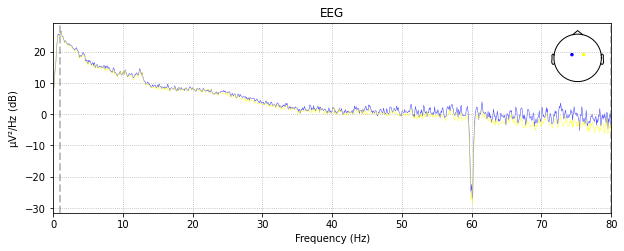

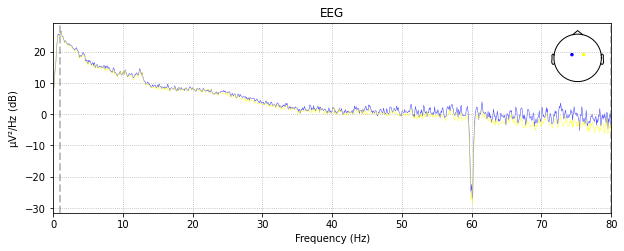

In [12]:
raw.filter(l_freq=1, h_freq=None)
raw.plot_psd(picks=['C1', 'C2'])

In [13]:
ica = mne.preprocessing.ICA(n_components=16, random_state=42)
ica.fit(raw)

C:\Users\DELL\AppData\Local\Temp/ipykernel_8104/185973250.py:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = mne.preprocessing.ICA(n_components=16, random_state=42)


<ICA | raw data decomposition, fit (fastica): 297120 samples, 16 components, channels used: "eeg">

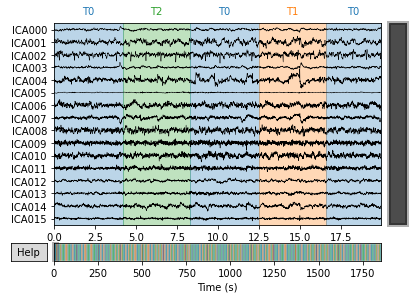

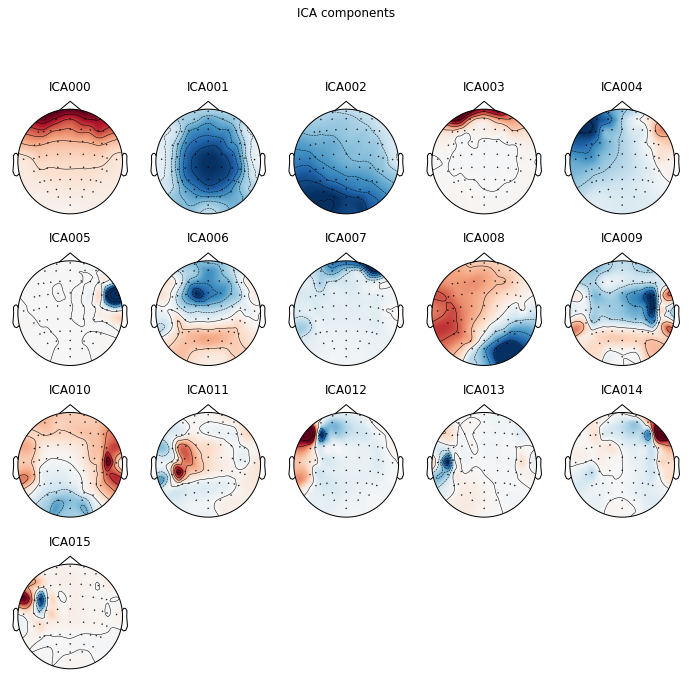

[<MNEFigure size 702x696.24 with 16 Axes>]

In [131]:
ica.plot_sources(raw)
ica.plot_components()

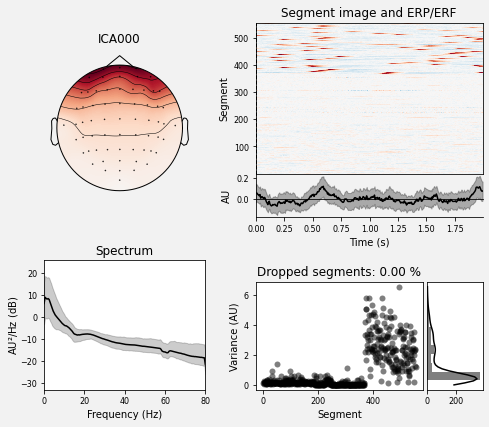

[<Figure size 504x432 with 6 Axes>]

In [75]:
ica.plot_properties(raw, picks=[0])

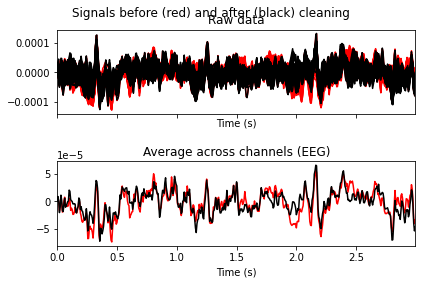

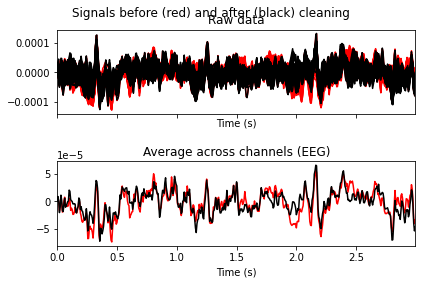

In [76]:
ica.plot_overlay(raw, exclude=[0])

In [14]:
ica.exclude = [0,1]
ica.apply(eeg.raw)
del raw


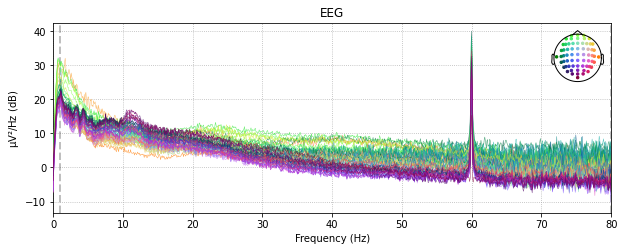

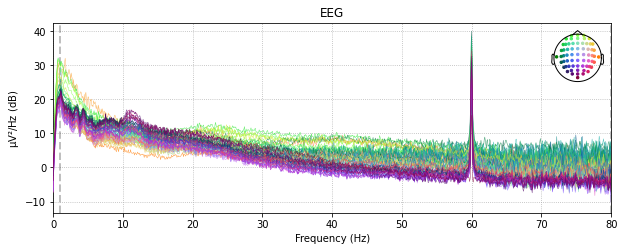

In [15]:
eeg.apply_filter(freq=(1,None))
eeg.raw.notch_filter(60)
eeg.raw.plot_psd()

<RawEDF | S001R06.edf, 64 x 297120 (1857.0 s), ~145.2 MB, data loaded>

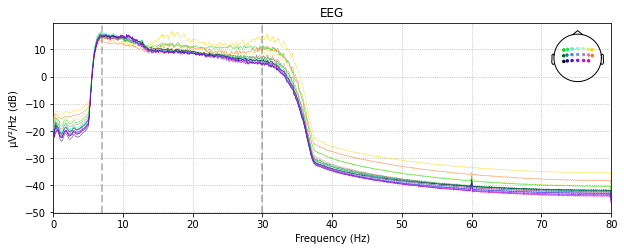

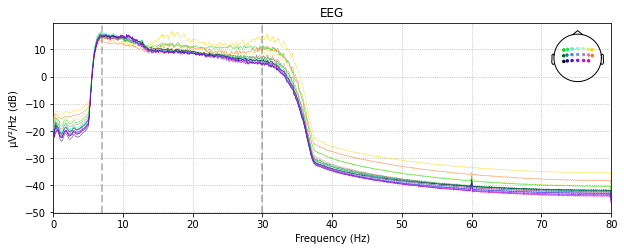

In [416]:
eeg.raw.plot_psd(picks=eeg.raw.ch_names[:20])

In [17]:
X, y = eeg.get_X_y(channel_selection=True, channels=['C1', 'C2'])
X.shape

(225, 2, 641)

#### STFT

In [456]:
spectogram = np.zeros((X.shape[0], X.shape[1], 8, 641))

IndexError: index 6 is out of bounds for axis 0 with size 6

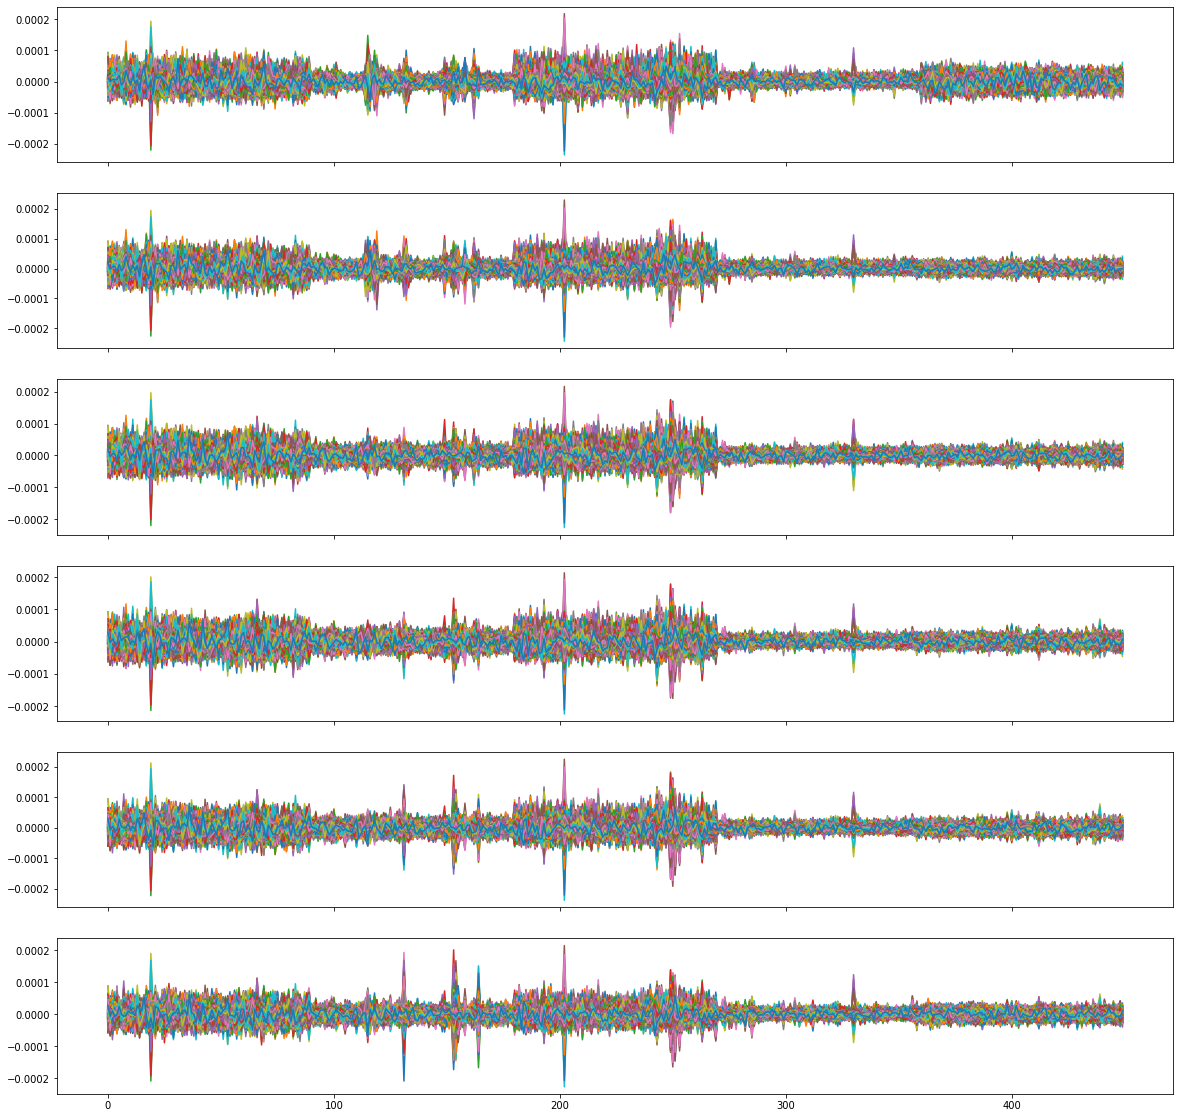

In [454]:
fig, ax = plt.subplots(6,1,figsize=(20,20),sharex=True)

for i in range(X.shape[1]):
    ax[i].plot(range(X.shape[0]),X[:,i])

In [457]:
fs = 160
nperseg = 15
noverlap = 14
window = 'hann'

for m in range(X.shape[0]):
    for channel in range(X.shape[1]):
        sig = X[m, channel, :]
        f, t, Zxx = signal.stft(sig, fs = fs, nperseg=nperseg, noverlap=noverlap)
        spectogram[m, channel, :, :] = np.abs(Zxx)

In [458]:
print(spectogram.shape)

(450, 21, 8, 641)


In [459]:
img = spectogram[0,0,:,:]
img.shape

(8, 641)

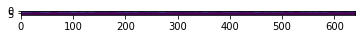

In [460]:
plt.imshow(spectogram[100,2,:,:])

### Convolutional Neural Network

In [489]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels1):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(input_channels, output_channels1, kernel_size=(3,3) ),  
                                    nn.ReLU(), nn.AvgPool2d(kernel_size=(1,3)))
        #output size = (450, 64, 6, 213)
        
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=(3,3) ),  
                                    nn.ReLU(), nn.AvgPool2d(kernel_size=(1,3)), nn.Dropout())
        #output size = (450, 128, 4, 70)
        
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),  
                                    nn.ReLU(), nn.AvgPool2d(kernel_size=(1,3)))
        #output size = (450, 256, 4, 23)
        
        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=(3,3) ),  
                                    nn.ReLU(), nn.AvgPool2d(kernel_size=(1,3)), nn.Dropout())
        #output size = (450, 512, 2, 7)
        
        self.fc = nn.Sequential( nn.Linear(7168, 2) ) 
                               
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        print(x.shape)
        x = x.reshape(-1, 7168)
        x = self.fc(x)
        return x

In [490]:
net = CNN(21, 64)
net = net.float()
#print(len(net.parameters()))

In [475]:
import torch.optim as optim

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = criterion.to(device)

In [476]:
X_tensor = torch.FloatTensor(spectogram)
y_tensor = torch.from_numpy(y)
X_tensor.shape

torch.Size([450, 21, 8, 641])

In [477]:
X_tensor.requires_grad=True

In [467]:
y_tensor.shape

torch.Size([450])

In [478]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_tensor, y_tensor)

train_size = int(X_tensor.size()[0] * 0.7)
valid_size = int(X_tensor.size()[0] * 0.3)

print(train_size, valid_size)

train_set, valid_set, test_set = torch.utils.data.random_split(train_data, [train_size, valid_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)


315 90 45


In [479]:
def train_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.train()
    
    for X, y in dataloader:
        X = Variable(X)
        y = Variable(y)
        X=X.to(device)
        y=y.to(device)
        
        optimizer.zero_grad()
        #print(y.type())
        yhat = net(X)
        #print(yhat.shape)
        #print(y.shape)
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        loss.backward()
        optimizer.step()
        
        _, yhat = torch.max(yhat.data, axis=1)
        #print(yhat)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Test accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [44]:
y.astype(np.int64)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0], dtype=int64)

In [480]:
def eval_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.eval()
    
    for X, y in dataloader:
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        yhat = net(X)
        
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        _, yhat = torch.max(yhat.data, axis=1)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Validation accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [491]:
n_epochs = 200
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
    yhat, train_loss, train_acc = train_model(net, train_iterator, optimizer, criterion)
    yhat, valid_loss, valid_acc = eval_model(net, valid_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    if (epoch) % 10 == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.3f}%')


Epoch: 55
	Train Loss: 0.693 | Train Acc: 0.50%
	 Val. Loss: 0.693 |  Val. Acc: 0.53%
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.4844)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.4219)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.5000)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.5156)
torch.Size([59, 512, 2, 7])
Test accuracy:  tensor(0.5932)
torch.Size([64, 512, 2, 7])
Validation accuracy:  tensor(0.5625)
torch.Size([26, 512, 2, 7])
Validation accuracy:  tensor(0.5000)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.4375)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.5469)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.4062)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.5156)
torch.Size([59, 512, 2, 7])
Test accuracy:  tensor(0.5424)
torch.Size([64, 512, 2, 7])
Validation accuracy:  tensor(0.4844)
torch.Size([26, 512, 2, 7])
Validation accuracy:  tensor(0.6923)
torch.Size([64, 512, 2, 7])
Test accuracy:  tensor(0.4062)
torch

KeyboardInterrupt: 

### CWT

In [216]:
widths = np.arange(1, 41)
cwtmatr = np.zeros((X.shape[0], X.shape[1], 40, 161))
for m in range(X.shape[0]):
    for channel in range(X.shape[1]):
        sig = X[m, channel, :]
        cwtmatr[m, channel, :, :] = signal.cwt(sig, signal.morlet2, widths)

print(cwtmatr.shape)


(225, 64, 40, 161)


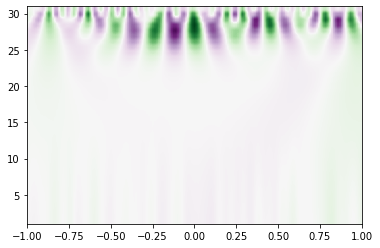

In [179]:
plt.imshow(cwtmatr[1][4], extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', 
           vmax=abs(cwtmatr[1][4]).max(), vmin=-abs(cwtmatr[1][4]).max())

In [219]:
class CNN2(nn.Module):
    def __init__(self, input_channels, output_channels1):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels1, kernel_size=(3,3) )  #output size = (225, 256, 38,159)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 64, kernel_size=(3,3) )  #output size = (225, 64, 36, 157)
        self.relu2 = nn.ReLU()
        self.fc = nn.Sequential(nn.Linear(361728, 320), nn.ReLU(), nn.Dropout(0.1),
                                #nn.Linear(640, 320), nn.ReLU(), nn.Dropout(0.1),
                               nn.Linear(320, 160), nn.ReLU(), nn.Dropout(0.1),
                               nn.Linear(160, 2), nn.Dropout(0.1))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.reshape(-1, 361728)
        x = self.fc(x)
        return x.squeeze(1)

In [220]:
net = CNN2(64, 256)
net = net.float()
#print(len(net.parameters()))

In [221]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = criterion.to(device)

In [222]:
X_tensor = torch.FloatTensor(cwtmatr)
y_tensor = torch.from_numpy(y)
X_tensor.shape

torch.Size([225, 64, 40, 161])

In [223]:
y_tensor.shape

torch.Size([225])

In [224]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_tensor, y_tensor)

train_size = round(X_tensor.size()[0] * 0.7)
valid_size = round(X_tensor.size()[0] * 0.2)
test_size = round(X_tensor.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(train_data, [train_size, valid_size, test_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [225]:
def train_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.train()
    
    for X, y in dataloader:
        
        X=X.to(device)
        y=y.to(device)
        #print(y.type())
        yhat = net(X)
        #print(yhat.shape)
        #print(y.shape)
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, yhat = torch.max(yhat.data, axis=1)
        #print(yhat)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Test accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [226]:
y.astype(np.int64)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0], dtype=int64)

In [227]:
def eval_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.eval()
    
    for X, y in dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        yhat = net(X)
        
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        _, yhat = torch.max(yhat.data, axis=1)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Validation accuracy: ", accuracy)
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [228]:
n_epochs = 200
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
    yhat, train_loss, train_acc = train_model(net, train_iterator, optimizer, criterion)
    yhat, valid_loss, valid_acc = eval_model(net, valid_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    if (epoch+1) % 5 == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model:{} saved.".format(type(net).__name__))
        torch.save(net.state_dict(), f'{type(net).__name__}.pth.tar')

Epoch: 20
	Train Loss: 0.681 | Train Acc: 0.58%
	 Val. Loss: 0.802 |  Val. Acc: 0.24%
Test accuracy:  tensor(0.5312)
Test accuracy:  tensor(0.6094)
Test accuracy:  tensor(0.7000)
Validation accuracy:  tensor(0.2444)
Test accuracy:  tensor(0.5156)
Test accuracy:  tensor(0.6094)
Test accuracy:  tensor(0.7333)
Validation accuracy:  tensor(0.2444)
Test accuracy:  tensor(0.6250)
Test accuracy:  tensor(0.6250)
Test accuracy:  tensor(0.4667)
Validation accuracy:  tensor(0.2444)
Test accuracy:  tensor(0.6875)
Test accuracy:  tensor(0.5312)
Test accuracy:  tensor(0.5333)
Validation accuracy:  tensor(0.2444)


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 395968512 bytes.

### CNN + Raw + Channel Selection

In [48]:
X.shape

(225, 2, 641)

In [49]:
X_norm = (X-X.mean(axis=0))/X.std(axis=0)
X_norm.shape

(225, 2, 641)

#### Reshape X to (batch, time series, electrode_channel)

In [50]:
xin = X_norm.transpose(0, 2, 1)
xin = xin[:, np.newaxis, :, :]
xin = torch.FloatTensor(xin)
y = torch.LongTensor(y)
xin.shape

torch.Size([225, 1, 641, 2])

In [30]:
xin = X.transpose(0, 2, 1)
xin = xin[:, np.newaxis, :, :]
xin = torch.FloatTensor(xin)
y = torch.LongTensor(y)
xin.shape

torch.Size([225, 1, 641, 2])

#### Convert to Tensor and make TensorDataset

In [272]:
from torch.utils.data import TensorDataset

itemData = TensorDataset(xin, y)

In [229]:
itemData[0][0].shape

torch.Size([1, 641, 2])

#### Make DataLoader from TensorDataset

In [230]:
from torch.utils.data import DataLoader

dloader = DataLoader(dataset=itemData, batch_size=64, shuffle=True )
item, label = next(iter(dloader))
item.shape

torch.Size([64, 1, 641, 2])

#### Add channel axis = 1 for input into CNN

In [103]:
item = item[:, np.newaxis, :, :]
item.shape

torch.Size([64, 1, 161, 2])

#### Convolutional Layer 1 - Temporal Convolution along TimeSeries axis

In [231]:
conv1 = nn.Conv1d(1, 25, kernel_size=(11,1))
item = conv1(item)
print(item.shape)
item = F.relu(item)
item = F.dropout(item, p=0.5)
item.shape

torch.Size([64, 25, 631, 2])


torch.Size([64, 25, 631, 2])

#### Convolution Layer 2 - Spatial Convolution along Electrode_channel axis (with MaxPool in Temporal)

In [232]:
conv2 = nn.Conv1d(25, 25, kernel_size=(1,2))
item = conv2(item)
print(item.shape)
item = F.relu(item)
mp = nn.MaxPool2d(kernel_size=(3,1))
item = mp(item)
item.shape

torch.Size([64, 25, 631, 1])


torch.Size([64, 25, 210, 1])

#### Convolution 3 - Temporal Convolution along Time Series axis (with MaxPool in Temporal)

In [233]:
conv3 = nn.Conv1d(25, 50, kernel_size=(11,1))
item = conv3(item)
print(item.shape)
item = F.relu(item)
item = F.dropout(item, p=0.5)
mp = nn.MaxPool2d(kernel_size=(3,1))
item = mp(item)
item.shape

torch.Size([64, 50, 200, 1])


torch.Size([64, 50, 66, 1])

#### Convolution 4 - Temporal Convolution along Time Series axis (with MaxPool in Temporal)

In [234]:
conv4 = nn.Conv1d(50, 100, kernel_size=(11,1))
item = conv4(item)
print(item.shape)
item = F.relu(item)
item = F.dropout(item, p=0.5)
mp = nn.MaxPool2d(kernel_size=(3,1))
item = mp(item)
item.shape

torch.Size([64, 100, 56, 1])


torch.Size([64, 100, 18, 1])

#### Convolution 5 - Temporal Convolution

In [236]:
conv5 = nn.Conv1d(100, 200, kernel_size=(11,1))
item = conv5(item)
print(item.shape)
item = F.relu(item)
item = F.dropout(item, p=0.5)
mp = nn.MaxPool2d(kernel_size=(2,1))
item = mp(item)
item.shape

torch.Size([64, 200, 8, 1])


torch.Size([64, 200, 4, 1])

#### Fully Connected Layer

In [237]:
linear = nn.Linear(800,2)
item = linear(item.reshape(-1, 800))
item.shape

torch.Size([64, 2])

#### Predictions

In [238]:
out = F.softmax(item)
_, yhat = torch.max(out, dim=1)
print(yhat)

tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0])


C:\Users\DELL\AppData\Local\Temp/ipykernel_17780/3585064606.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(item)


In [239]:
yhat.shape

torch.Size([64])

#### Accuracy

In [240]:
torch.sum(yhat==label)/label.shape[0]

tensor(0.5625)

#### Modified CNN Model

In [51]:
class CNN3(nn.Module):
    def __init__(self, input_channels, output_channels):     # input (450, 1, 641, 2)
        super(CNN3, self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        self.conv1 = nn.Sequential(nn.Conv1d(input_channels, input_channels*25, kernel_size=(11,1)), 
                                   nn.LeakyReLU(), nn.Dropout(p=0.5))
        # output (450, 25, 631, 2)
        
        self.conv2 = nn.Sequential(nn.Conv1d(input_channels*25, input_channels*25, kernel_size=(1,2)), 
                                   nn.BatchNorm2d(input_channels*25),
                                   nn.LeakyReLU(), nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 25, 210, 1)
        
        self.conv3 = nn.Sequential(nn.Conv1d(input_channels*25, input_channels*50, kernel_size=(11,1)), 
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 50, 66, 1)
        
        self.conv4 = nn.Sequential(nn.Conv1d(input_channels*50, input_channels*100, kernel_size=(11,1)), 
                                   nn.BatchNorm2d(input_channels*100),
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(3,1)))
        # output (450, 100, 18, 1)
        
        self.conv5 = nn.Sequential(nn.Conv1d(input_channels*100, input_channels*200, kernel_size=(11,1)), 
                                   nn.BatchNorm2d(input_channels*200),
                                   nn.LeakyReLU(), nn.Dropout(p=0.5),
                                   nn.MaxPool2d(kernel_size=(2,1)))
        # output (450, 200, 4, 1)
        
        #self.fc = nn.Linear(800,2)
        self.fc = nn.Linear(input_channels*200*4, output_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        print('x:', x.shape)
        x = x.reshape(-1, self.input_channels*200*4)
        x = self.fc(x)
        return x

In [52]:
net = CNN3(1, 2)
net = net.float()
#print(len(net.parameters()))

In [53]:
import torch.optim as optim

learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = criterion.to(device)

In [54]:
X_tensor = xin
y_tensor = y
X_tensor.shape

torch.Size([225, 1, 641, 2])

In [55]:
X_tensor.requires_grad=True

In [56]:
from torch.utils.data import TensorDataset

train_data = TensorDataset(X_tensor, y_tensor)

train_size = round(X_tensor.size()[0] * 0.7)
valid_size = round(X_tensor.size()[0] * 0.2)
test_size = round(X_tensor.size()[0] * 0.1)

train_set, valid_set, test_set = torch.utils.data.random_split(train_data, [train_size, valid_size, test_size])

BATCH_SIZE = 64 #keeping it binary so it fits GPU

#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

In [57]:
def train_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.train()
    
    for X, y in dataloader:
        
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        #print(y.type())
        yhat = net(X)
        print(yhat.shape)
        print(y.shape)
        
        loss = criterion(yhat, y.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        
        _, yhat = torch.max(yhat.data, axis=1)

        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Train accuracy: ", accuracy.item())
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [58]:
def eval_model(net, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_accuracy = []
    
    net.eval()
    
    for X, y in dataloader:
        
        X = Variable(X)
        y = Variable(y)
        X = X.to(device)
        y = y.to(device)
        
        yhat = net(X)
        loss = criterion(yhat, y.type(torch.LongTensor))
        
        _, yhat = torch.max(yhat.data, axis=1)
        accuracy = torch.sum(yhat==y)/y.shape[0]
        print(f"Validation accuracy: ", accuracy.item())
        
        epoch_loss += loss.item()
        epoch_accuracy.append(accuracy)
        
    return yhat, epoch_loss/len(dataloader), np.mean(epoch_accuracy)

In [59]:
n_epochs = 500
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []
best_valid_loss = np.inf

for epoch in range(n_epochs):
    yhat, train_loss, train_acc = train_model(net, train_iterator, optimizer, criterion)
    yhat, valid_loss, valid_acc = eval_model(net, valid_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracy.append(train_acc)
    valid_accuracy.append(valid_acc)
    
    if (epoch+1) % 5 == 0:
        clear_output(wait=True)
        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {100*train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {100*valid_acc:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Model:{} saved.".format(type(net).__name__))
        torch.save(net.state_dict(), f'{type(net).__name__}.pth.tar')

Epoch: 500
	Train Loss: 0.060 | Train Acc: 98.44%
	 Val. Loss: 0.840 |  Val. Acc: 53.33%


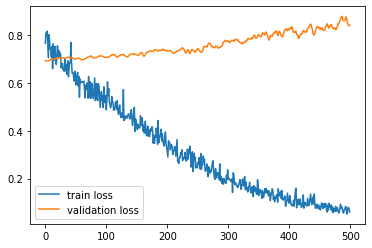

In [67]:
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

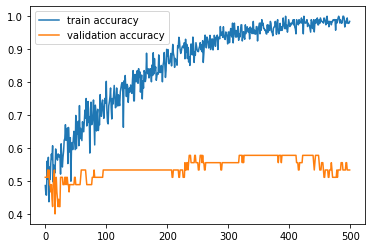

In [68]:
plt.plot(train_accuracy, label='train accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

### Prediction on the Test Dataset

In [60]:
items, labels = next(iter(test_iterator))

In [61]:
items.requires_grad

True

In [66]:
yhat = net(items)
print(yhat.shape)
_,yhat = torch.max(yhat, dim=1)

print('Predictions:', yhat.data)
print('Accuracy: ', (torch.sum(yhat.squeeze()==labels)/labels.shape[0]).item())

x: torch.Size([22, 200, 4, 1])
torch.Size([22, 2])
Predictions: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1])
Accuracy:  0.40909090638160706


### Further Tasks

Given X and y, perform Binary Classification to correctly identify an event as T1 or T2. 

<p>T1 = Clenching Fists  (Real or imagining)</p>
T2 = Moving Feet      (Real or imagining)

**Possible methods which may be used:**
1. <s>Logistic Regression (Linearly separable data only)</s>
2. <s>State Vector Machines</s>
3. <s>Linear Discriminant Analysis</s>
4. CNN + LSTM

**We may also try Feature Engineering and Selection to improve accuracy of our model.**
1. Artifact Handling using ICA (may be better to let the deep learning model handle it)
2. <s>Common Spatial Patterns Algorithm to extract features</s>
3. <s>Using a subset of functionally-relevant Electrodes (channels)</s>
4. Applying Baseline to the training data to get less noisy signal
5. Short-time Fast Fourier Transform
6. Wavelet Transform